In [17]:
import sys

from ompl import util as ou
from ompl import base as ob
from ompl import geometric as og

import math
import copy
import numpy as np
from numpy import linalg as LA
from urdf_parser_py.urdf import URDF
# from pykdl_utils.kdl_parser import kdl_tree_from_urdf_model
from pykdl_utils.kdl_kinematics import KDLKinematics





In [18]:

def quaternion_rotation_matrix(Q):
    """
    Covert a quaternion into a full three-dimensional rotation matrix.
 
    Input
    :param Q: A 4 element array representing the quaternion (q0,q1,q2,q3) 
 
    Output
    :return: A 3x3 element matrix representing the full 3D rotation matrix. 
             This rotation matrix converts a point in the local reference 
             frame to a point in the global reference frame.
    """
    # Extract the values from Q
    q0 = Q[0]
    q1 = Q[1]
    q2 = Q[2]
    q3 = Q[3]
     
    # First row of the rotation matrix
    r00 = 2 * (q0 * q0 + q1 * q1) - 1
    r01 = 2 * (q1 * q2 - q0 * q3)
    r02 = 2 * (q1 * q3 + q0 * q2)
     
    # Second row of the rotation matrix
    r10 = 2 * (q1 * q2 + q0 * q3)
    r11 = 2 * (q0 * q0 + q2 * q2) - 1
    r12 = 2 * (q2 * q3 - q0 * q1)
     
    # Third row of the rotation matrix
    r20 = 2 * (q1 * q3 - q0 * q2)
    r21 = 2 * (q2 * q3 + q0 * q1)
    r22 = 2 * (q0 * q0 + q3 * q3) - 1
     
    # 3x3 rotation matrix
    rot_matrix = [[r00, r01, r02],[r10, r11, r12],[r20, r21, r22]]
                            
    return rot_matrix

In [19]:
f = open('/home/sai_kumar/iiwa7_setup/src/iiwa7_with_tool/urdf/iiwa7_with_tool.urdf', 'r')
robot = URDF.from_xml_string(f.read())  # parsed URDF
ee_kin = KDLKinematics(robot, "iiwa_link_0", "tcp")
ur_kin = KDLKinematics(robot, "iiwa_link_0", "iiwa_link_ee")
# p_trocar = np.array([[ 9.10937772e-01],[-1.31414659e-12],[ 6.54741958e-01]])
p_trocar = np.array([[-0.63218696], [0.0000982], [0.760526907]])
p_task = np.array([[-0.932186], [-0.151], [0.6605]])
p_task2 = np.array([[-0.932186], [-0.451], [0.6605]])


Unknown tag "material" in /robot[@name='iiwa7']/link[@name='iiwa_link_0']/collision[1]
Unknown tag "self_collision_checking" in /robot[@name='iiwa7']/link[@name='iiwa_link_0']
Unknown tag "material" in /robot[@name='iiwa7']/link[@name='iiwa_link_1']/collision[1]
Unknown tag "material" in /robot[@name='iiwa7']/link[@name='iiwa_link_2']/collision[1]
Unknown tag "material" in /robot[@name='iiwa7']/link[@name='iiwa_link_3']/collision[1]
Unknown tag "material" in /robot[@name='iiwa7']/link[@name='iiwa_link_4']/collision[1]
Unknown tag "material" in /robot[@name='iiwa7']/link[@name='iiwa_link_5']/collision[1]
Unknown tag "material" in /robot[@name='iiwa7']/link[@name='iiwa_link_6']/collision[1]
Unknown tag "material" in /robot[@name='iiwa7']/link[@name='iiwa_link_7']/collision[1]
Unknown tag "hardwareInterface" in /robot[@name='iiwa7']/transmission[@name='iiwa_tran_1']/actuator[@name='iiwa_motor_1']
Unknown tag "robotNamespace" in /robot[@name='iiwa7']/transmission[@name='iiwa_tran_1']
Unkno

In [20]:
def constraintfunction(q = ur_kin.random_joint_angles()):
    
    out = np.zeros((3,1), dtype=np.float64)
    
    
    p_i = ur_kin.forward(q)[:3, 3]
    p_t = ee_kin.forward(q)[:3, 3]

    AP = p_trocar - p_i
    
    d = p_t - p_i
    

    # dist = LA.norm(np.cross(np.transpose(AP), np.transpose(d)))/LA.norm(d)
    lam = np.dot(np.transpose(AP), d)[0,0]/LA.norm(d)**2
    p_rcm = p_i + lam*(p_t - p_i)
    # print("P_rcm: ",p_rcm)

    out[0] = (p_rcm - p_trocar)[0,:]
    out[1] = (p_rcm - p_trocar)[1,:]
    out[2] = (p_rcm - p_trocar)[2,:]

    
    return out

In [21]:
def jacobian(q = ur_kin.random_joint_angles()):
        
        out = np.zeros((3, 7), dtype=np.float64)
        
        
        
        p_i = ur_kin.forward(q)[:3, 3]
        p_t = ee_kin.forward(q)[:3, 3]

        AP = np.array(p_trocar - p_i)
        d = np.array(p_t - p_i)


        lam = np.dot(np.transpose(AP), d)[0,0]/LA.norm(d)**2
        J_i = ur_kin.jacobian(q)[:3]
        J_t = ee_kin.jacobian(q)[:3]


        p_rcm = p_i + lam*(p_t - p_i)
        J_rcm = J_i + lam*(J_t - J_i)

        # Dcap = p_trocar - p_rcm

        # J = np.dot(np.transpose(Dcap), J_rcm)
        # nrm = np.linalg.norm(J)
        # if np.isfinite(nrm) and nrm > 0:
        #     out[0, :] = [J[0, 0], J[0, 1], J[0, 2], J[0, 3], J[0, 4], J[0, 5], J[0, 6]]
        # else:
        #     out[0, :] = [1, 0, 0, 0, 0, 0, 0]
        out[0] = (J_rcm)[0,:]
        out[1] = (J_rcm)[1,:]
        out[2] = (J_rcm)[2,:]

        return out

In [22]:
def projectionFunction(q =ur_kin.random_joint_angles()):
    # print("q: ", q)
    fx = constraintfunction(q)
    

    while np.linalg.norm(fx) > 0.005:
        jc = jacobian(q)
        invj = np.linalg.pinv(jc)
        dq = np.matmul(invj, fx)
        dq = np.transpose(dq)[0]
        q = q - dq
        # print(q)
        
        
        

        fx = constraintfunction(q)
        # print(np.linalg.norm(fx))

    return q




In [23]:
def RCMjacobian(q=ur_kin.random_joint_angles()):
        
        out = np.zeros((6, 7), dtype=np.float64)
        
        
        
        p_i = ur_kin.forward(q)[:3, 3]
        p_t = ee_kin.forward(q)[:3, 3]

        AP = np.array(p_trocar - p_i)
        d = np.array(p_t - p_i)


        lam = np.dot(np.transpose(AP), d)[0,0]/LA.norm(d)**2
        J_i = ur_kin.jacobian(q)[:3]
        J_t = ee_kin.jacobian(q)[:3]


        p_rcm = p_i + lam*(p_t - p_i)
        J_rcm = J_i + lam*(J_t - J_i)

        # Dcap = p_trocar - p_rcm

        # J = np.dot(np.transpose(Dcap), J_rcm)
        # nrm = np.linalg.norm(J)
        # if np.isfinite(nrm) and nrm > 0:
        #     out[0, :] = [J[0, 0], J[0, 1], J[0, 2], J[0, 3], J[0, 4], J[0, 5], J[0, 6]]
        # else:
        #     out[0, :] = [1, 0, 0, 0, 0, 0, 0]
        out[0] = (J_t)[0,:]
        out[1] = (J_t)[1,:]
        out[2] = (J_t)[2,:]
        out[3] = (J_rcm)[0,:]
        out[4] = (J_rcm)[1,:]
        out[5] = (J_rcm)[2,:]

        return out

In [24]:
def RCMImpl(q, p_ts):
        
        J_ext = np.zeros((6, 7), dtype=np.float64)
        
        
        
        p_i = ur_kin.forward(q)[:3, 3]
        p_t = ee_kin.forward(q)[:3, 3]

        AP = np.array(p_trocar - p_i)
        d = np.array(p_t - p_i)


        lam = np.dot(np.transpose(AP), d)[0,0]/LA.norm(d)**2
        J_i = ur_kin.jacobian(q)[:3]
        J_t = ee_kin.jacobian(q)[:3]


        p_rcm = p_i + lam*(p_t - p_i)
        J_rcm = J_i + lam*(J_t - J_i)

        E = np.zeros([6, 1])
    
        E[:3,:] = p_ts- p_t
        E[3:, :] = p_trocar - p_rcm

        if np.linalg.norm(p_ts- p_t) < 0.0001 and np.linalg.norm(p_trocar - p_rcm)<0.005:
                return None

        J_ext[0] = (J_t)[0,:]
        J_ext[1] = (J_t)[1,:]
        J_ext[2] = (J_t)[2,:]
        J_ext[3] = (J_rcm)[0,:]
        J_ext[4] = (J_rcm)[1,:]
        J_ext[5] = (J_rcm)[2,:]

        J_pinv = np.linalg.pinv(J_ext)
        dq = np.matmul(J_pinv, E)
        dq = np.transpose(dq)[0]

        return dq

In [25]:
q1 = np.array([0.1, 0.6941, 0.0000, 1.2947, 0.000, -1.3995, 0.000])

reached = False
while not reached:
    dq = RCMImpl(q1, p_task)
    if dq is None:
        reached = True
        break
    q1 = q1 + 0.1*dq
print(q1)
q2 = q1
reached = False
while not reached:
    dq = RCMImpl(q2, p_task2)
    if dq is None:
        reached = True
        break
    q2 = q2 + 0.1*dq

print(q2)

[ 9.60050610e-01  2.73851870e-01 -1.08900846e+00  1.31654225e+00
  5.79913958e-01 -9.36431306e-01  6.80116083e-17]
[ 2.28496881e+00  6.31398187e-01 -1.90597645e+00  9.28598785e-01
  4.96832666e-01 -1.03696726e+00 -2.76363773e-18]


In [26]:

print(np.linalg.norm(q2-q1))
q_proj = []





1.6486947604132665


In [27]:
q = q1
i = 0
while np.linalg.norm(ee_kin.forward(q1)[:3, 3] -ee_kin.forward(q2)[:3, 3]) > 0.0001:
    q = q1 + (q2 - q1)/np.linalg.norm(q2 - q1)*0.001
    q1 = projectionFunction(q)
    q_proj.append(q1)
    i = i + 1
    print(i)
print(q_proj)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [28]:
# for i in range(101):
#     q = q1 + (q2 - q1)*i/100
#     q_p = projectionFunction(q)
#     # print(q_p)

    
#     print(i)
#     q_proj.append(q_p)

# print(q_proj)

In [29]:
import  matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

[[-0.9320577191982016, -0.15112670549075374, 0.6607489172420812], [-0.9320131957645865, -0.15129547908922764, 0.660969682684518], [-0.9319686855387662, -0.1514641459623162, 0.6611902167383996], [-0.9319241887698764, -0.15163270623598837, 0.6614105192652393], [-0.9318797057068002, -0.15180116003669472, 0.6616305901267044], [-0.9318352365981655, -0.1519695074913672, 0.661850429184617], [-0.9317907816923441, -0.15213774872741864, 0.662070036300954], [-0.9317463412374514, -0.15230588387274144, 0.6622894113378465], [-0.931701915481346, -0.15247391305570832, 0.6625085541575806], [-0.9316575046716269, -0.15264183640517176, 0.6627274646225977], [-0.9316131090556352, -0.15280965405046176, 0.662946142595493], [-0.9315687288804504, -0.15297736612138815, 0.6631645879390184], [-0.9315243643928925, -0.15314497274823743, 0.66338280051608], [-0.9314800158395193, -0.15331247406177456, 0.663600780189739], [-0.9314356834666253, -0.1534798701932407, 0.663818526823212], [-0.9313913675202417, -0.15364716127

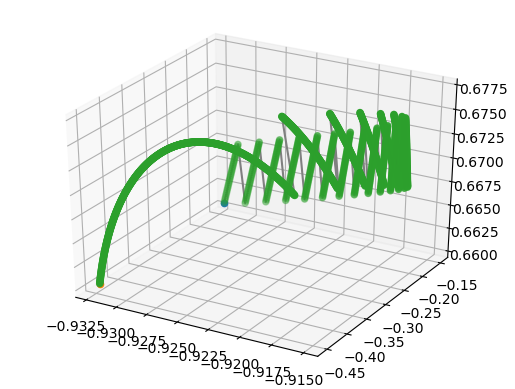

In [30]:
ee_list  = []
for i in q_proj:
    e = ee_kin.forward(i)[:3, 3]
    ee_list.append([e[0,0], e[1,0], e[2,0]])

print(ee_list)

fig = plt.figure()
ax = plt.axes(projection='3d')
x_data = []
y_data = []
z_data = []
for i in ee_list:
    x_data.append(i[0])
    y_data.append(i[1])
    z_data.append(i[2])

ax.scatter3D(x_data[0],y_data[0],z_data[0], 'red')
ax.scatter3D(x_data[-1],y_data[-1],z_data[-1], 'green')
ax.plot3D(x_data,y_data,z_data, 'gray')
ax.scatter3D(x_data,y_data,z_data, 'red')

plt.show()

[[-5.301022521941867e-06, -7.537439099503834e-05, 0.00012994360873741506], [-1.0521322113876685e-05, -0.00015058963847083167, 0.00025977638764362876], [-1.565727518049176e-05, -0.00022565182867211769, 0.00038949570986435145], [-2.0709119882722504e-05, -0.00030056096863840425, 0.0005191013469973971], [-2.5677094418030677e-05, -0.00037531706587808804, 0.0006485930708935994], [-3.056143701740677e-05, -0.0004499201283690097, 0.0007779706536571451], [-3.536238594492591e-05, -0.0005243701645582733, 0.000907233867646795], [-4.00801794963046e-05, -0.0005986671833613583, 0.001036382485475329], [-4.471505599767944e-05, -0.0006728111941624943, 0.0011654162800114332], [-4.926725380416386e-05, -0.0007468022068149799, 0.0012943350243794782], [-5.373701129884889e-05, -0.0008206402316393097, 0.0014231384919599632], [-5.812456689080481e-05, -0.0008943252794255053, 0.001551826456391292], [-6.243015901508109e-05, -0.0009678573614301456, 0.0016803986915689961], [-6.665402612993088e-05, -0.0010412364893783

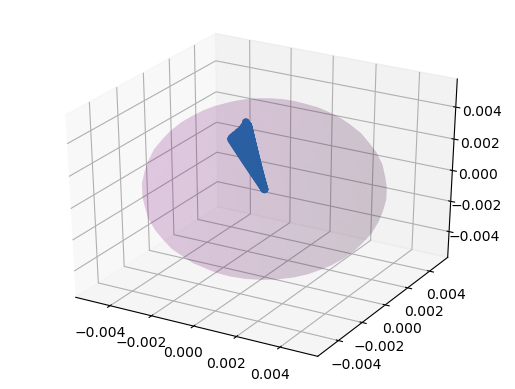

In [31]:
rcm_list  = []
for i in q_proj:
    e = constraintfunction(i)
    rcm_list.append([e[0,0], e[1,0], e[2,0]])

print(rcm_list)

fig = plt.figure()
ax = plt.axes(projection='3d')
x_data = []
y_data = []
z_data = []
for i in rcm_list:
    x_data.append(i[0])
    y_data.append(i[1])
    z_data.append(i[2])
# ax.plot3D(x_data,y_data,z_data, 'gray')
ax.scatter3D(x_data,y_data,z_data, 'red')

r = 0.005
u, v = np.mgrid[0:2 * np.pi:30j, 0:np.pi:20j]
x = r*np.cos(u) * np.sin(v)
y = r*np.sin(u) * np.sin(v)
z = r*np.cos(v)
ax.plot_surface(x, y, z, alpha = 0.1, color='purple')

plt.show()

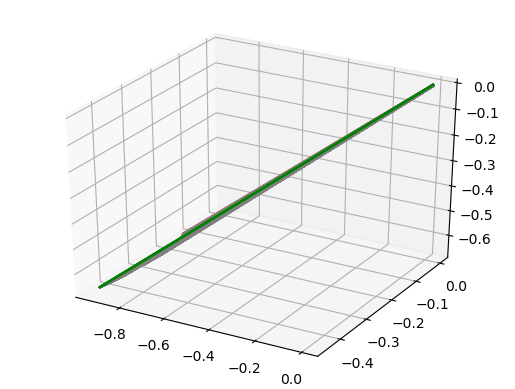

In [32]:
fig = plt.figure()
ax = plt.axes(projection='3d')
i = 0
x_data0 = [ee_list[i][0], rcm_list[i][0]]
y_data0 = [ee_list[i][1], rcm_list[i][1]]
z_data0 = [-ee_list[i][2], -rcm_list[i][2]]
ax.plot3D(x_data0,y_data0,z_data0, 'red', linewidth=2)
for i in range(len(ee_list)):
    x_data = [ee_list[i][0], rcm_list[i][0]]
    y_data = [ee_list[i][1], rcm_list[i][1]]
    z_data = [-ee_list[i][2], -rcm_list[i][2]]
    ax.plot3D(x_data,y_data,z_data, 'gray')
i = len(ee_list) - 1
x_data1 = [ee_list[i][0], rcm_list[i][0]]
y_data1 = [ee_list[i][1], rcm_list[i][1]]
z_data1 = [-ee_list[i][2], -rcm_list[i][2]]
ax.plot3D(x_data1,y_data1,z_data1, 'green',linewidth=2)

plt.show()